## Set GPU using tensorflow

In [1]:
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

## Define Keras Model

In [2]:
from keras.layers import Dense,CuDNNLSTM,CuDNNGRU

Using TensorFlow backend.


In [1]:
import matlab.engine
from datetime import datetime
import tensorflow as tf
from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Input,Dense, Dropout, BatchNormalization, Activation
from keras import backend as K
from keras.callbacks import Callback
#from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras import optimizers
#from sklearn import linear_model
#from sklearn import preprocessing
import matplotlib.pyplot as plt
#from sklearn.utils import shuffle
from tensorflow import keras
import time
from sklearn.metrics import r2_score
import numpy as np
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [4]:
iteration=0
no_of_sources=3
batch_size=1
samples_per_snr=1000
weight_file="source=3_sir.hdf5"

In [5]:
def matToPyReshape(matArray):
    pyArray=np.zeros((samples_per_snr,16,10))
    for i in range(0,samples_per_snr):
        C=matArray[0,:,i]
        for j in range(1,16):
            C=np.column_stack((C,matArray[j,:,i]))
        pyArray[i,:]=C.T
    return pyArray
    

#### Define a checkpoint callback:

In [6]:
def r_m_s_e(y_true, y_pred):
        print(K.int_shape(y_pred))
   # if no_of_sources==1:
   #     return K.sqrt(K.mean(K.square(K.abs(y_pred-y_true)))) 
   # else:
        total=no_of_sources*batch_size
        
        b=K.repeat_elements(y_true,no_of_sources,axis=0)
        print("b ",K.int_shape(b))
        c=K.repeat_elements(y_pred,no_of_sources,axis=1)
        print(K.int_shape(c))
        c=K.reshape(c,(total,no_of_sources))
        print(K.int_shape(c))
        d=b-c
        print(K.int_shape(d))
        d=K.abs(d)
        mini1=K.min(d,axis=1)
        print(K.int_shape(mini1))
        mini1=K.reshape(mini1,(batch_size,no_of_sources))
        print(K.int_shape(mini1)) 
        return K.sqrt(K.mean(K.square(mini1),axis=-1))

In [7]:
#checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint_name1 = weight_file
checkpoint1 = ModelCheckpoint(checkpoint_name1, monitor="loss", verbose = 1, save_best_only = False, mode ='auto')



In [8]:
#X_train, Y_train = shuffle(X_train, Y_train, random_state=0)

###  Batch normalization after a  & dr1=0.01 dr2=0.1

In [9]:
eng = matlab.engine.start_matlab()

In [10]:
rate=0.001
model = Sequential()
dr=0
#model.add(RepeatVector(16,input_shape=(256,)))

model.add(CuDNNLSTM(128,return_sequences=True,kernel_initializer="glorot_normal",input_shape=(10,32)))
model.add(Dropout(dr))
#model.add(BatchNormalization())
model.add(CuDNNLSTM(128,return_sequences=False,kernel_initializer="glorot_normal"))
model.add(Dropout(dr))
#model.add(BatchNormalization())
#model.add(Dropout(dr))

model.add(Dense(no_of_sources, kernel_initializer='he_normal'))
adam=optimizers.Adam(lr=rate)
model.compile(optimizer=adam, loss=r_m_s_e, metrics=[r_m_s_e])
model.load_weights(weight_file)

callbacks_list = [checkpoint1]
#model.compile(loss='categorical_crossentropy',
              #optimizer='adam', metrics=["accuracy"])


W0909 09:10:11.367518 139894041777920 deprecation_wrapper.py:119] From /home/iiitd/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0909 09:10:11.370416 139894041777920 deprecation_wrapper.py:119] From /home/iiitd/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0909 09:10:11.704246 139894041777920 deprecation_wrapper.py:119] From /home/iiitd/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0909 09:10:11.877819 139894041777920 deprecation_wrapper.py:119] From /home/iiitd/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Ple

(None, 3)
b  (None, None)
(None, 9)
(3, 3)
(3, 3)
(3,)
(1, 3)
(None, 3)
b  (None, None)
(None, 9)
(3, 3)
(3, 3)
(3,)
(1, 3)


In [11]:
def Signal_gen(snr):
    X_real, X_imag, label =eng.doa(snr,samples_per_snr,no_of_sources,nargout=3)
    X_real=np.asarray(X_real)
    X_imag=np.asarray(X_imag)
    label=np.asarray(label)
    a=matToPyReshape(X_real)
    b=matToPyReshape(X_imag)
    X_real_imag=np.zeros((samples_per_snr,32,10))
    for j in range(samples_per_snr):
        X_real_imag[j,]=np.concatenate((a[j,],b[j,]),axis=0)
        
    m=np.zeros((X_real_imag.shape[0],X_real_imag.shape[2],X_real_imag.shape[1]))
    for i in range(X_real_imag.shape[0]):
        for j in range(X_real_imag.shape[2]):
            m[i,j,:]=X_real_imag[i,:,j]
    X_real_imag=m
    
    #PREPROCESSING
    scaler = MinMaxScaler()
    for k in range(X_real_imag.shape[0]):
        X_real_imag[k,:,:]=scaler.fit_transform(X_real_imag[k,:,:])
    return X_real_imag,label

In [12]:
#SNRs=[10.0,15.0,20.0,25.0]
SNRs=[10.0,15.0,20.0,25.0]
while True:
    X_train, y_train=Signal_gen(5.0)
    for snr in SNRs:
        X, y=Signal_gen(snr)
        X_train=np.vstack((X_train,X))
        y_train=np.vstack((y_train,y))
    model.fit(X_train,y_train,epochs=1,callbacks=callbacks_list,verbose=1,batch_size=batch_size,shuffle=False)
    iteration=iteration+1
    print(iteration)

W0909 09:10:20.878964 139894041777920 deprecation.py:323] From /home/iiitd/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/1
5000/5000 [==============================] - 17s 3ms/step - loss: 7.9433 - r_m_s_e: 7.9433

Epoch 00001: saving model to source=3_sir.hdf5
1
Epoch 1/1
5000/5000 [==============================] - 18s 4ms/step - loss: 8.5758 - r_m_s_e: 8.5758

Epoch 00001: saving model to source=3_sir.hdf5
2
Epoch 1/1
5000/5000 [==============================] - 18s 4ms/step - loss: 8.2569 - r_m_s_e: 8.2569

Epoch 00001: saving model to source=3_sir.hdf5
3
Epoch 1/1
5000/5000 [==============================] - 18s 4ms/step - loss: 7.6835 - r_m_s_e: 7.6835

Epoch 00001: saving model to source=3_sir.hdf5
4
Epoch 1/1
5000/5000 [==============================] - 18s 4ms/step - loss: 8.1584 - r_m_s_e: 8.1584

Epoch 00001: saving model to source=3_sir.hdf5
5
Epoch 1/1
5000/5000 [==============================] - 18s 4ms/step - loss: 7.8252 - r_m_s_e: 7.8252

Epoch 00001: saving model to source=3_sir.hdf5
6
Epoch 1/1
5000/5000 [==============================] - 18s 4ms/step - loss: 7.7297 - r_m_s_e: 

54
Epoch 1/1
5000/5000 [==============================] - 18s 4ms/step - loss: 8.2597 - r_m_s_e: 8.2597

Epoch 00001: saving model to source=3_sir.hdf5
55
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 8.5620 - r_m_s_e: 8.5620

Epoch 00001: saving model to source=3_sir.hdf5
56
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 8.3436 - r_m_s_e: 8.3436

Epoch 00001: saving model to source=3_sir.hdf5
57
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 8.3822 - r_m_s_e: 8.3822

Epoch 00001: saving model to source=3_sir.hdf5
58
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 7.8700 - r_m_s_e: 7.8700

Epoch 00001: saving model to source=3_sir.hdf5
59
Epoch 1/1
5000/5000 [==============================] - 18s 4ms/step - loss: 8.2804 - r_m_s_e: 8.2804

Epoch 00001: saving model to source=3_sir.hdf5
60
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 8.8361 - 

Epoch 1/1
5000/5000 [==============================] - 21s 4ms/step - loss: 7.8394 - r_m_s_e: 7.8394

Epoch 00001: saving model to source=3_sir.hdf5
109
Epoch 1/1
5000/5000 [==============================] - 21s 4ms/step - loss: 7.5516 - r_m_s_e: 7.5516

Epoch 00001: saving model to source=3_sir.hdf5
110
Epoch 1/1
5000/5000 [==============================] - 21s 4ms/step - loss: 6.9887 - r_m_s_e: 6.9887

Epoch 00001: saving model to source=3_sir.hdf5
111
Epoch 1/1
5000/5000 [==============================] - 21s 4ms/step - loss: 6.8803 - r_m_s_e: 6.8803

Epoch 00001: saving model to source=3_sir.hdf5
112
Epoch 1/1
1294/5000 [======>.......................] - ETA: 15s - loss: 6.6802 - r_m_s_e: 6.6802

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5000/5000 [==============================] - 18s 4ms/step - loss: 7.1885 - r_m_s_e: 7.1885

Epoch 00001: saving model to source=3_sir.hdf5
132
Epoch 1/1
5000/5000 [==============================] - 18s 4ms/step - loss: 7.5489 - r_m_s_e: 7.5489

Epoch 00001: saving model to source=3_sir.hdf5
133
Epoch 1/1
5000/5000 [==============================] - 18s 4ms/step - loss: 6.9248 - r_m_s_e: 6.9248

Epoch 00001: saving model to source=3_sir.hdf5
134
Epoch 1/1
5000/5000 [==============================] - 18s 4ms/step - loss: 6.7588 - r_m_s_e: 6.7588

Epoch 00001: saving model to source=3_sir.hdf5
135
Epoch 1/1
5000/5000 [==============================] - 18s 4ms/step - loss: 6.9103 - r_m_s_e: 6.9103

Epoch 00001: saving model to source=3_sir.hdf5
136
Epoch 1/1
5000/5000 [==============================] - 18s 4ms/step - loss: 8.6614 - r_m_s_e: 8.6614

Epoch 00001: saving model to source=3_sir.hdf5
137
Epoch 1/1
5000/5000 [==============================] - 18s 4ms/step - loss: 8.1895 - r_m_s_e

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5000/5000 [==============================] - 19s 4ms/step - loss: 7.1176 - r_m_s_e: 7.1176

Epoch 00001: saving model to source=3_sir.hdf5
160
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 7.4195 - r_m_s_e: 7.4195

Epoch 00001: saving model to source=3_sir.hdf5
161
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 7.9110 - r_m_s_e: 7.9110

Epoch 00001: saving model to source=3_sir.hdf5
162
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 8.5221 - r_m_s_e: 8.5221

Epoch 00001: saving model to source=3_sir.hdf5
163
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 8.2469 - r_m_s_e: 8.2469

Epoch 00001: saving model to source=3_sir.hdf5
164
Epoch 1/1
5000/5000 [==============================] - 18s 4ms/step - loss: 7.2933 - r_m_s_e: 7.2933

Epoch 00001: saving model to source=3_sir.hdf5
165
Epoch 1/1
5000/5000 [==============================] - 18s 4ms/step - loss: 6.6057 - r_m_s_e

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5000/5000 [==============================] - 20s 4ms/step - loss: 6.8928 - r_m_s_e: 6.8928

Epoch 00001: saving model to source=3_sir.hdf5
189
Epoch 1/1
5000/5000 [==============================] - 20s 4ms/step - loss: 7.8786 - r_m_s_e: 7.8786

Epoch 00001: saving model to source=3_sir.hdf5
190
Epoch 1/1
5000/5000 [==============================] - 20s 4ms/step - loss: 6.9990 - r_m_s_e: 6.9990

Epoch 00001: saving model to source=3_sir.hdf5
191
Epoch 1/1
5000/5000 [==============================] - 20s 4ms/step - loss: 7.0571 - r_m_s_e: 7.0571

Epoch 00001: saving model to source=3_sir.hdf5
192
Epoch 1/1
5000/5000 [==============================] - 20s 4ms/step - loss: 6.5937 - r_m_s_e: 6.5937

Epoch 00001: saving model to source=3_sir.hdf5
193
Epoch 1/1
5000/5000 [==============================] - 20s 4ms/step - loss: 6.6699 - r_m_s_e: 6.6699

Epoch 00001: saving model to source=3_sir.hdf5
194
Epoch 1/1
5000/5000 [==============================] - 20s 4ms/step - loss: 6.3484 - r_m_s_e

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5000/5000 [==============================] - 20s 4ms/step - loss: 8.4153 - r_m_s_e: 8.4153

Epoch 00001: saving model to source=3_sir.hdf5
216
Epoch 1/1
5000/5000 [==============================] - 23s 5ms/step - loss: 8.9878 - r_m_s_e: 8.9878

Epoch 00001: saving model to source=3_sir.hdf5
217
Epoch 1/1
5000/5000 [==============================] - 20s 4ms/step - loss: 8.6900 - r_m_s_e: 8.6900

Epoch 00001: saving model to source=3_sir.hdf5
218
Epoch 1/1
5000/5000 [==============================] - 21s 4ms/step - loss: 8.5368 - r_m_s_e: 8.5368

Epoch 00001: saving model to source=3_sir.hdf5
219
Epoch 1/1
5000/5000 [==============================] - 23s 5ms/step - loss: 8.9289 - r_m_s_e: 8.9289

Epoch 00001: saving model to source=3_sir.hdf5
220
Epoch 1/1
5000/5000 [==============================] - 20s 4ms/step - loss: 9.7190 - r_m_s_e: 9.7190

Epoch 00001: saving model to source=3_sir.hdf5
221
Epoch 1/1
5000/5000 [==============================] - 20s 4ms/step - loss: 8.0145 - r_m_s_e

5000/5000 [==============================] - 20s 4ms/step - loss: 6.9399 - r_m_s_e: 6.9399

Epoch 00001: saving model to source=3_sir.hdf5
269
Epoch 1/1
5000/5000 [==============================] - 20s 4ms/step - loss: 7.8175 - r_m_s_e: 7.8175

Epoch 00001: saving model to source=3_sir.hdf5
270
Epoch 1/1
5000/5000 [==============================] - 20s 4ms/step - loss: 8.5713 - r_m_s_e: 8.5713

Epoch 00001: saving model to source=3_sir.hdf5
271
Epoch 1/1
5000/5000 [==============================] - 20s 4ms/step - loss: 7.4648 - r_m_s_e: 7.4648

Epoch 00001: saving model to source=3_sir.hdf5
272
Epoch 1/1
5000/5000 [==============================] - 20s 4ms/step - loss: 7.2943 - r_m_s_e: 7.2943

Epoch 00001: saving model to source=3_sir.hdf5
273
Epoch 1/1
5000/5000 [==============================] - 20s 4ms/step - loss: 8.8476 - r_m_s_e: 8.8476

Epoch 00001: saving model to source=3_sir.hdf5
274
Epoch 1/1
5000/5000 [==============================] - 20s 4ms/step - loss: 6.1434 - r_m_s_e

5000/5000 [==============================] - 23s 5ms/step - loss: 6.8219 - r_m_s_e: 6.8219

Epoch 00001: saving model to source=3_sir.hdf5
322
Epoch 1/1
5000/5000 [==============================] - 20s 4ms/step - loss: 6.2648 - r_m_s_e: 6.2648

Epoch 00001: saving model to source=3_sir.hdf5
323
Epoch 1/1
5000/5000 [==============================] - 20s 4ms/step - loss: 6.1569 - r_m_s_e: 6.1569

Epoch 00001: saving model to source=3_sir.hdf5
324
Epoch 1/1
5000/5000 [==============================] - 20s 4ms/step - loss: 5.3878 - r_m_s_e: 5.3878

Epoch 00001: saving model to source=3_sir.hdf5
325
Epoch 1/1
5000/5000 [==============================] - 22s 4ms/step - loss: 5.4609 - r_m_s_e: 5.4609

Epoch 00001: saving model to source=3_sir.hdf5
326
Epoch 1/1
5000/5000 [==============================] - 21s 4ms/step - loss: 5.2739 - r_m_s_e: 5.2739

Epoch 00001: saving model to source=3_sir.hdf5
327
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 5.9180 - r_m_s_e

5000/5000 [==============================] - 20s 4ms/step - loss: 7.6408 - r_m_s_e: 7.6408

Epoch 00001: saving model to source=3_sir.hdf5
375
Epoch 1/1
5000/5000 [==============================] - 20s 4ms/step - loss: 7.8208 - r_m_s_e: 7.8208

Epoch 00001: saving model to source=3_sir.hdf5
376
Epoch 1/1
5000/5000 [==============================] - 20s 4ms/step - loss: 7.3037 - r_m_s_e: 7.3037

Epoch 00001: saving model to source=3_sir.hdf5
377
Epoch 1/1
5000/5000 [==============================] - 20s 4ms/step - loss: 6.8934 - r_m_s_e: 6.8934

Epoch 00001: saving model to source=3_sir.hdf5
378
Epoch 1/1
5000/5000 [==============================] - 20s 4ms/step - loss: 7.0043 - r_m_s_e: 7.0043

Epoch 00001: saving model to source=3_sir.hdf5
379
Epoch 1/1
5000/5000 [==============================] - 20s 4ms/step - loss: 6.5449 - r_m_s_e: 6.5449

Epoch 00001: saving model to source=3_sir.hdf5
380
Epoch 1/1
5000/5000 [==============================] - 20s 4ms/step - loss: 6.9126 - r_m_s_e

5000/5000 [==============================] - 20s 4ms/step - loss: 7.3473 - r_m_s_e: 7.3473

Epoch 00001: saving model to source=3_sir.hdf5
428
Epoch 1/1
5000/5000 [==============================] - 20s 4ms/step - loss: 6.9659 - r_m_s_e: 6.9659

Epoch 00001: saving model to source=3_sir.hdf5
429
Epoch 1/1
5000/5000 [==============================] - 20s 4ms/step - loss: 7.3518 - r_m_s_e: 7.3518

Epoch 00001: saving model to source=3_sir.hdf5
430
Epoch 1/1
5000/5000 [==============================] - 20s 4ms/step - loss: 7.5041 - r_m_s_e: 7.5041

Epoch 00001: saving model to source=3_sir.hdf5
431
Epoch 1/1
5000/5000 [==============================] - 20s 4ms/step - loss: 6.7890 - r_m_s_e: 6.7890

Epoch 00001: saving model to source=3_sir.hdf5
432
Epoch 1/1
5000/5000 [==============================] - 20s 4ms/step - loss: 6.6575 - r_m_s_e: 6.6575

Epoch 00001: saving model to source=3_sir.hdf5
433
Epoch 1/1
5000/5000 [==============================] - 20s 4ms/step - loss: 7.0866 - r_m_s_e

5000/5000 [==============================] - 19s 4ms/step - loss: 9.2432 - r_m_s_e: 9.2432

Epoch 00001: saving model to source=3_sir.hdf5
481
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 9.6328 - r_m_s_e: 9.6328

Epoch 00001: saving model to source=3_sir.hdf5
482
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 8.7544 - r_m_s_e: 8.7544

Epoch 00001: saving model to source=3_sir.hdf5
483
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 8.0124 - r_m_s_e: 8.0124

Epoch 00001: saving model to source=3_sir.hdf5
484
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 7.9165 - r_m_s_e: 7.9165

Epoch 00001: saving model to source=3_sir.hdf5
485
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 8.0133 - r_m_s_e: 8.0133

Epoch 00001: saving model to source=3_sir.hdf5
486
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 7.6949 - r_m_s_e

5000/5000 [==============================] - 18s 4ms/step - loss: 7.4526 - r_m_s_e: 7.4526

Epoch 00001: saving model to source=3_sir.hdf5
534
Epoch 1/1
5000/5000 [==============================] - 20s 4ms/step - loss: 6.7831 - r_m_s_e: 6.7831

Epoch 00001: saving model to source=3_sir.hdf5
535
Epoch 1/1
5000/5000 [==============================] - 20s 4ms/step - loss: 6.6473 - r_m_s_e: 6.6473

Epoch 00001: saving model to source=3_sir.hdf5
536
Epoch 1/1
5000/5000 [==============================] - 18s 4ms/step - loss: 7.3712 - r_m_s_e: 7.3712

Epoch 00001: saving model to source=3_sir.hdf5
537
Epoch 1/1
5000/5000 [==============================] - 18s 4ms/step - loss: 6.9183 - r_m_s_e: 6.9183

Epoch 00001: saving model to source=3_sir.hdf5
538
Epoch 1/1
5000/5000 [==============================] - 18s 4ms/step - loss: 7.6346 - r_m_s_e: 7.6346

Epoch 00001: saving model to source=3_sir.hdf5
539
Epoch 1/1
5000/5000 [==============================] - 20s 4ms/step - loss: 7.2062 - r_m_s_e

5000/5000 [==============================] - 18s 4ms/step - loss: 6.4547 - r_m_s_e: 6.4547

Epoch 00001: saving model to source=3_sir.hdf5
587
Epoch 1/1
5000/5000 [==============================] - 18s 4ms/step - loss: 7.4811 - r_m_s_e: 7.4811

Epoch 00001: saving model to source=3_sir.hdf5
588
Epoch 1/1
5000/5000 [==============================] - 18s 4ms/step - loss: 6.5632 - r_m_s_e: 6.5632

Epoch 00001: saving model to source=3_sir.hdf5
589
Epoch 1/1
5000/5000 [==============================] - 18s 4ms/step - loss: 6.4817 - r_m_s_e: 6.4817

Epoch 00001: saving model to source=3_sir.hdf5
590
Epoch 1/1
5000/5000 [==============================] - 20s 4ms/step - loss: 6.9643 - r_m_s_e: 6.9643

Epoch 00001: saving model to source=3_sir.hdf5
591
Epoch 1/1
5000/5000 [==============================] - 20s 4ms/step - loss: 6.4957 - r_m_s_e: 6.4957

Epoch 00001: saving model to source=3_sir.hdf5
592
Epoch 1/1
5000/5000 [==============================] - 20s 4ms/step - loss: 6.6645 - r_m_s_e

5000/5000 [==============================] - 19s 4ms/step - loss: 7.6268 - r_m_s_e: 7.6268

Epoch 00001: saving model to source=3_sir.hdf5
640
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 7.3747 - r_m_s_e: 7.3747

Epoch 00001: saving model to source=3_sir.hdf5
641
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 6.9759 - r_m_s_e: 6.9759

Epoch 00001: saving model to source=3_sir.hdf5
642
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 6.5144 - r_m_s_e: 6.5144

Epoch 00001: saving model to source=3_sir.hdf5
643
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 7.0703 - r_m_s_e: 7.0703

Epoch 00001: saving model to source=3_sir.hdf5
644
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 7.0155 - r_m_s_e: 7.0155

Epoch 00001: saving model to source=3_sir.hdf5
645
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 6.9861 - r_m_s_e

5000/5000 [==============================] - 20s 4ms/step - loss: 7.4557 - r_m_s_e: 7.4557

Epoch 00001: saving model to source=3_sir.hdf5
693
Epoch 1/1
5000/5000 [==============================] - 20s 4ms/step - loss: 7.5839 - r_m_s_e: 7.5839

Epoch 00001: saving model to source=3_sir.hdf5
694
Epoch 1/1
5000/5000 [==============================] - 20s 4ms/step - loss: 8.9059 - r_m_s_e: 8.9059

Epoch 00001: saving model to source=3_sir.hdf5
695
Epoch 1/1
5000/5000 [==============================] - 20s 4ms/step - loss: 8.9016 - r_m_s_e: 8.9016

Epoch 00001: saving model to source=3_sir.hdf5
696
Epoch 1/1
5000/5000 [==============================] - 20s 4ms/step - loss: 8.6251 - r_m_s_e: 8.6251

Epoch 00001: saving model to source=3_sir.hdf5
697
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 9.0746 - r_m_s_e: 9.0746

Epoch 00001: saving model to source=3_sir.hdf5
698
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 8.3292 - r_m_s_e

5000/5000 [==============================] - 19s 4ms/step - loss: 6.8871 - r_m_s_e: 6.8871

Epoch 00001: saving model to source=3_sir.hdf5
746
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 7.2776 - r_m_s_e: 7.2776

Epoch 00001: saving model to source=3_sir.hdf5
747
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 7.4333 - r_m_s_e: 7.4333

Epoch 00001: saving model to source=3_sir.hdf5
748
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 7.4692 - r_m_s_e: 7.4692

Epoch 00001: saving model to source=3_sir.hdf5
749
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 7.9735 - r_m_s_e: 7.9735

Epoch 00001: saving model to source=3_sir.hdf5
750
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 7.1910 - r_m_s_e: 7.1910

Epoch 00001: saving model to source=3_sir.hdf5
751
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 8.4399 - r_m_s_e

KeyboardInterrupt: 

### Evaluate the results

In [13]:
model.load_weights(weight_file)

W0909 08:34:49.100958 140057684707072 deprecation_wrapper.py:119] From /home/iiitd/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0909 08:34:49.101950 140057684707072 deprecation_wrapper.py:119] From /home/iiitd/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



In [13]:
samples_per_snr=50000

In [14]:
SNRs=[5.0,10.0,15.0,20.0,25.0]
b1=np.zeros((5,))
b2=np.zeros((5,))
i=0
for snr in SNRs:
        X_test, y_test=Signal_gen(snr)
        b1[i]=model.evaluate(X_test,y_test,verbose=0,batch_size=batch_size)[0]
        b2[i]=model.evaluate(X_test,y_test,verbose=0,batch_size=batch_size)[1]
        i=i+1

In [16]:
b2

array([8.17313746, 7.33334756, 7.20596606, 7.15551975, 7.1017206 ])

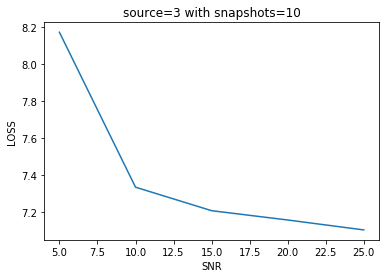

In [15]:
x = np.linspace(5, 25, 5)

plt.plot(x, b2, label='linear')
plt.title('source=3 with snapshots=10')
plt.ylabel('LOSS')
plt.xlabel('SNR')
#plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [8]:
source_3= np.array([8.17313746, 7.33334756, 7.20596606, 7.15551975, 7.1017206 ])
source_2 =np.array([5.58432459, 4.98970056, 4.86629341, 4.87640249, 4.90003241])
source_1=np.array([5.20301109, 4.38032443, 3.75389371, 3.58996002, 3.80943039])
source_4=np.array([8.42300696, 8.29529771, 8.28299472, 8.23252039, 8.26706113])

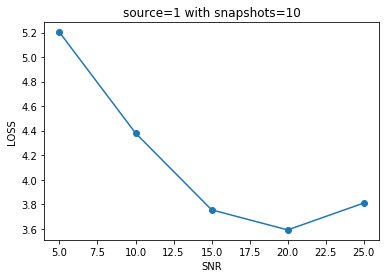

In [12]:
x = np.linspace(5, 25, 5)

plt.plot(x, source_1, label='linear',marker='o')

plt.title('source=1 with snapshots=10')
plt.ylabel('LOSS')
plt.xlabel('SNR')
#plt.legend(['train', 'test'], loc='upper left')
plt.show()

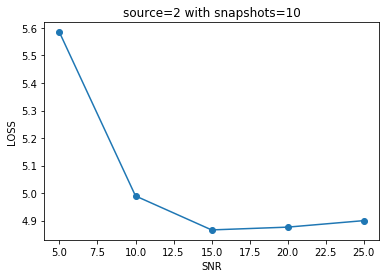

In [13]:
x = np.linspace(5, 25, 5)

plt.plot(x, source_2, label='linear',marker='o')

plt.title('source=2 with snapshots=10')
plt.ylabel('LOSS')
plt.xlabel('SNR')
#plt.legend(['train', 'test'], loc='upper left')
plt.show()

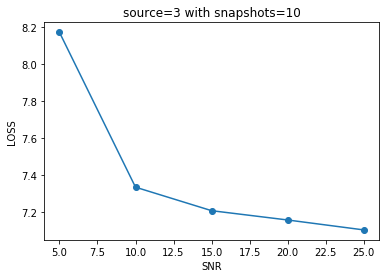

In [15]:
x = np.linspace(5, 25, 5)

plt.plot(x, source_3, label='linear',marker='o')

plt.title('source=3 with snapshots=10')
plt.ylabel('LOSS')
plt.xlabel('SNR')
#plt.legend(['train', 'test'], loc='upper left')
plt.show()

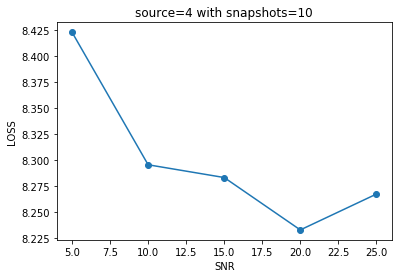

In [16]:
x = np.linspace(5, 25, 5)

plt.plot(x, source_4, label='linear',marker='o')

plt.title('source=4 with snapshots=10')
plt.ylabel('LOSS')
plt.xlabel('SNR')
#plt.legend(['train', 'test'], loc='upper left')
plt.show()

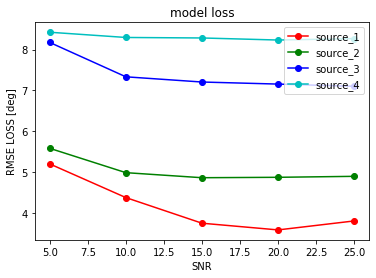

In [11]:
x = np.linspace(5, 25, 5)
plt.plot(x,source_1, label='linear',color='r',marker='o')
plt.plot(x,source_2, label='linear',color='g',marker='o')
plt.plot(x,source_3, label='linear',color='b',marker='o')
plt.plot(x,source_4, label='linear',color='c',marker='o')
plt.title('model loss')
plt.ylabel('RMSE LOSS [deg]')
plt.xlabel('SNR')
plt.legend(['source_1','source_2', 'source_3','source_4'], loc='upper right')
plt.show()

In [ ]:
model.save_weights("weight_initialization_sir.hdf5")

In [ ]:
#SNRs=[10.0,15.0,20.0,25.0]
SNRs=[5.0,10.0,15.0,20.0,25.0]
while True:
    for snr in SNRs:
        X, y=Signal_gen(snr)
        loss=model.train_on_batch(X, y)
        print(loss)
    iteration=iteration+1
    print(iteration)

In [ ]:
model.evaluate(X_test[60000:],Y_test[60000:], verbose=0)[0]

In [ ]:
def r_m_s_e(y_true, y_pred):
        print(K.int_shape(y_pred))
   # if no_of_sources==1:
   #     return K.sqrt(K.mean(K.square(K.abs(y_pred-y_true)))) 
   # else:
        total=no_of_sources*batch_size
        
        b=K.repeat_elements(y_true,no_of_sources,axis=0)
        print("b ",K.int_shape(b))
        c=K.repeat_elements(y_pred,no_of_sources,axis=1)
        print(K.int_shape(c))
        c=K.reshape(c,(total,no_of_sources))
        print(K.int_shape(c))
        d=b-c
        print(K.int_shape(d))
        d=K.abs(d)
        mini1=K.min(d,axis=1)
        print(K.int_shape(mini1))
        mini1=K.reshape(mini1,(batch_size,no_of_sources))
        print(K.int_shape(mini1))
        
        return K.sqrt(K.mean(K.square(mini1),axis=-1)) 

In [ ]:
with open('/trainHistoryDict', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [ ]:
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['r_m_s_e'])
plt.plot(history.history['val_r_m_s_e'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
a=np.arange(24)
a

In [ ]:
a=a.reshape((4,3,2))
a

In [ ]:
b=np.zeros((4,3))

In [ ]:
for i in range(4):
    b[i,]=a[i,:,0]

In [ ]:
b

In [ ]:
a=b

In [ ]:
a

In [ ]:
a[2:]

In [ ]:
from sklearn.utils import shuffle
import numpy as np

X = np.array([[0, 0, 0], [1, 1, 1], [2, 2, 2], [3, 3, 3], [4, 4, 4]])
y = np.array([0, 1, 2, 3, 4])
y=y.reshape((5,1))
X, y = shuffle(X, y)
print(X)
print(y)



In [ ]:
import numpy as np

In [ ]:
X1=np.arange(24)

In [ ]:
X1

In [ ]:
X1=X1.reshape((4,3,2))

In [ ]:
X1

In [ ]:
m=np.zeros((X1.shape[0],X1.shape[2],X1.shape[1]))
for i in range(X1.shape[0]):
    for j in range(X1.shape[2]):
        m[i,j,:]=X1[i,:,j]

In [ ]:
X1=m

In [ ]:
X2=np.arange(24,48)

In [ ]:
X2.shape

In [ ]:
X2=X2.reshape((4,2,3))

In [ ]:
X2

In [ ]:
c=np.vstack((X1,X2))
c.shape

In [ ]:
c

In [ ]:
import numpy as np

In [ ]:
a=np.array([1,2])

In [ ]:
a

In [ ]:
y_pred=K.variable([[1,2,11,30]])
y_true=K.variable([[10,11,30,50]])

In [ ]:
z=K.variable([[y_true[0]-y_pred[0],  y_true[0]-y_pred[1],  y_true[0]-y_pred[2],  y_true[0]-y_pred[3]]])

In [ ]:
K.eval(y_true)

In [ ]:
top=2
y_pred, y_pred_ind_k = tf.nn.top_k(y_pred, top)
y_true, y_true_ind_k = tf.nn.top_k(y_true, top)

In [ ]:
K.eval(y_pred)

In [ ]:
y_true, y_true_ind_k = tf.nn.top_k(y_true, top)

In [ ]:
K.eval(y_true)

In [ ]:
np_y_pred=np.array([1,2,11,30])
np_y_true=np.array([10,11,30,50])

In [ ]:
c=np.zeros((4,))

In [ ]:
one_sided=helper(np_y_pred,np_y_true)
two_sided=helper(np_y_true,np_y_pred)

In [ ]:
one_sided

In [ ]:
two_sided

In [ ]:
combined=np.concatenate([one_sided,two_sided])

In [ ]:
combined

In [ ]:
for i in range(0,4):
    for j in range(0,4):
        a=abs(np_y_true[j]-np_y_pred[i])
        print(a)
        b[j]=a
    c[i]=min(b)

In [ ]:
c

In [ ]:
ker=K.variable(value=combined)

In [ ]:
K.eval(K.sqrt(K.mean(K.square(ker))) )

In [ ]:
K.eval(ker)

In [ ]:
d=K.eval(ker)

In [ ]:
d

In [ ]:
X_real, X_imag, label =eng.Copy_of_doa(5.0,nargout=3)
X_real=np.asarray(X_real)
X_imag=np.asarray(X_imag)
label=np.asarray(label)

In [ ]:
label.shape

In [ ]:
X_real.shape

In [ ]:
y_pred=np.array([[1,2,11,30],
                 [3,4,9,10]])
y_true=np.array([[10,11,30,50],
                 [9,10,11,12]])
y_pred.shape

In [ ]:
y_pred=y_pred.reshape((2,1,4))
y_pred

In [ ]:
one=np.ones((2,4,1))

In [ ]:
b=np.dot(one,y_pred, axes=1)

In [ ]:
b.shape

In [ ]:
b

In [ ]:
a=np.array([[1,2,11,30], [1,2,4,5]])

In [ ]:
b = np.repeat(a, 4, axis=0)

In [ ]:
b

In [ ]:
c=np.array([[10,11,30,50], [5,4,9,10]])

In [ ]:
c=np.array([[10,11,30,50], [5,4,9,10]])
c = np.repeat(c, len(c[0]), axis=1)
print(c)
print(c.shape)

c = c.reshape(8, 4)
print(c)

In [ ]:
d=np.subtract(b,c)

In [ ]:
d=np.abs(d)

In [ ]:
d

In [ ]:
mini=np.min(d, axis=1)

In [ ]:
mini=mini.reshape(2,4)

In [ ]:
mini

In [ ]:
d=d.reshape(2,4,4)

In [ ]:
d

In [ ]:
mini=np.min(d, axis=1)
mini

In [ ]:
no_of_sources=2
batch_size=4

In [ ]:
def r_m_s_e(y_true, y_pred):
        print(K.int_shape(y_pred))
   # if no_of_sources==1:
   #     return K.sqrt(K.mean(K.square(K.abs(y_pred-y_true)))) 
   # else:
        total=no_of_sources*batch_size
        
        b=K.repeat_elements(y_true,no_of_sources,axis=0)
        print("b ",K.int_shape(b))
        c=K.repeat_elements(y_pred,no_of_sources,axis=1)
        print(K.int_shape(c))
        c=K.reshape(c,(total,no_of_sources))
        print(K.int_shape(c))
        d=b-c
        print(K.int_shape(d))
        d=K.abs(d)
        mini1=K.min(d,axis=1)
        print(K.int_shape(mini1))
        mini1=K.reshape(mini1,(batch_size,no_of_sources))
        print(K.int_shape(mini1))
        
        return K.sqrt(K.mean(K.square(mini1),axis=-1)) 

In [ ]:
y_true = K.variable([[10,5],
                    [9,3],
                    [8,7],
                    [6,5]])
y_pred = K.variable([[8,9],
                    [8,4],
                    [9,10],
                    [14,15]])
#Aloss=r_m_s_e(y_true,y_pred)
#print(K.eval(loss))


In [ ]:
K.eval(r_m_s_e(y_true,y_pred))

In [ ]:
y_true.shape

In [ ]:
def mean_np(y_true,y_pred):
    return np.mean(np.square((y_pred-y_true)))

In [ ]:
def mean_squared_error_k(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)

In [ ]:
K.eval(mean_squared_error_k(y_true,y_pred))

In [ ]:
def mean_squared_error(y_true, y_pred):
    return K.mean(K.square(y_pred-y_true),axis = -1)

In [ ]:
loss=mean_squared_error(y_true,y_pred)
print(K.eval(loss))


In [ ]:
def mean_squared_error(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true))

In [ ]:
y=mean_squared_error(y_true,y_pred)

In [ ]:
y.shape

In [ ]:
K.eval(y)